# Get the latest node list from Bitnodes API

In [1]:
# import requests
import requests

In [2]:
headers = {'Accept': 'application/json; indent=4',}
bitnodes_data = requests.get('https://bitnodes.earn.com/api/v1/snapshots/latest/', headers=headers)

# Convert Bitnodes API output to CSV

In [3]:
# import pandas
import pandas as pd

In [4]:
# read the JSON into a DataFrame
bitnodes = pd.read_json(bitnodes_data.text)
bitnodes.head()

,timestamp,total_nodes,latest_height,nodes
1.159.26.250:8333,2018-11-30 07:36:29,10492,552013,"[70015, /Satoshi:0.17.0/, 1543357242, 1037, 55..."
1.234.70.66:8333,2018-11-30 07:36:29,10492,552013,"[70015, /Satoshi:0.15.1/, 1542977255, 13, 5520..."
1.240.13.82:8333,2018-11-30 07:36:29,10492,552013,"[70015, /Satoshi:0.16.0/, 1542977255, 1037, 55..."
1.255.226.216:8333,2018-11-30 07:36:29,10492,552013,"[70015, /Satoshi:0.16.0/, 1541473494, 1037, 55..."
1.32.63.58:8333,2018-11-30 07:36:29,10492,552013,"[70015, /Satoshi:0.13.2/, 1541762606, 13, 5520..."


In [5]:
# examine how many records (e.g., mining nodes)
len(bitnodes)

10492

In [6]:
# looking at the above DataFrame, we are interested in the 'nodes' field
bitnodes.nodes[1]

[70015,
 '/Satoshi:0.15.1/',
 1542977255,
 13,
 552013,
 '1.234.70.66',
 'Seoul',
 'KR',
 37.5985,
 126.9783,
 'Asia/Seoul',
 'AS9318',
 'SK Broadband Co Ltd']

In [7]:
# node list fields have these names:
# 'Protocol version', 'User agent', 'Connected since', 'Services', 'Height', 'Hostname', 'City', 'Country code', 'LAT', 'LON', 'Timezone', 'ASN', 'Organization name'
# create a nodes column list
node_fields = ['Protocol_version', 'User_agent', 'Connected_since', 'Services', 'Height', 'Hostname', 'City', 'Country_code', 'LAT', 'LON', 'Timezone', 'ASN', 'Organization_name']

# create a new dataframe from the 'nodes' list field above with the column names
bitnodes_nodes = pd.DataFrame(bitnodes.nodes.values.tolist(), columns=node_fields)
bitnodes_nodes.head()

,Protocol_version,User_agent,Connected_since,Services,Height,Hostname,City,Country_code,LAT,LON,Timezone,ASN,Organization_name
0,70015,/Satoshi:0.17.0/,1543357242,1037,552013,cpe-1-159-26-250.vb12.vic.asp.telstra.net,None,AU,-33.4940,143.2104,None,AS1221,Telstra Pty Ltd
1,70015,/Satoshi:0.15.1/,1542977255,13,552013,1.234.70.66,Seoul,KR,37.5985,126.9783,Asia/Seoul,AS9318,SK Broadband Co Ltd
2,70015,/Satoshi:0.16.0/,1542977255,1037,552013,1.240.13.82,None,KR,37.5112,126.9741,Asia/Seoul,AS9318,SK Broadband Co Ltd
3,70015,/Satoshi:0.16.0/,1541473494,1037,552013,1.255.226.216,None,KR,37.5112,126.9741,Asia/Seoul,AS9318,SK Broadband Co Ltd
4,70015,/Satoshi:0.13.2/,1541762606,13,552013,1.32.63.58,Petaling Jaya,MY,3.1070,101.6305,Asia/Kuala_Lumpur,AS4788,"TM Net, Internet Service Provider"


In [8]:
# convert the Unix timestamp to YYYY-DD-MM hh:mm:ss format
bitnodes_nodes['Connected_since'] = pd.to_datetime(bitnodes_nodes['Connected_since'], unit='s')
bitnodes_nodes.head()

,Protocol_version,User_agent,Connected_since,Services,Height,Hostname,City,Country_code,LAT,LON,Timezone,ASN,Organization_name
0,70015,/Satoshi:0.17.0/,2018-11-27 22:20:42,1037,552013,cpe-1-159-26-250.vb12.vic.asp.telstra.net,None,AU,-33.4940,143.2104,None,AS1221,Telstra Pty Ltd
1,70015,/Satoshi:0.15.1/,2018-11-23 12:47:35,13,552013,1.234.70.66,Seoul,KR,37.5985,126.9783,Asia/Seoul,AS9318,SK Broadband Co Ltd
2,70015,/Satoshi:0.16.0/,2018-11-23 12:47:35,1037,552013,1.240.13.82,None,KR,37.5112,126.9741,Asia/Seoul,AS9318,SK Broadband Co Ltd
3,70015,/Satoshi:0.16.0/,2018-11-06 03:04:54,1037,552013,1.255.226.216,None,KR,37.5112,126.9741,Asia/Seoul,AS9318,SK Broadband Co Ltd
4,70015,/Satoshi:0.13.2/,2018-11-09 11:23:26,13,552013,1.32.63.58,Petaling Jaya,MY,3.1070,101.6305,Asia/Kuala_Lumpur,AS4788,"TM Net, Internet Service Provider"


In [9]:
# check to make sure we have the same number of records
len(bitnodes_nodes) == len(bitnodes)

True

In [10]:
# save the new nodes DataFrame as a CSV
bitnodes_nodes.to_csv('data/bitnodes.csv', encoding='utf-8')

### Mapping US-based nodes

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.speedups # does this help?
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# import states and nodes data
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')
nodes = pd.read_csv('data/bitnodes.csv')

In [4]:
states.crs

{'init': 'epsg:4269'}

In [5]:
# create a GeoDataFrame from the CSV data and use the NAD 83 epsg:4269 CRS
geoms = [Point(xy) for xy in zip(nodes.LON, nodes.LAT)]
crs = {'init' :'epsg:4326'}
nodes_geo = gpd.GeoDataFrame(nodes, crs=crs, geometry=geoms)

In [ ]:
# clip points to US


In [ ]:
# reproject into NAD83
states_eqdc = states.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
nodes_eqdc = nodes_geo.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

[(20, 50), (-128, -65)]

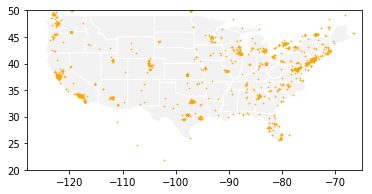

In [6]:
# plot all the data to have a look
fig, ax = plt.subplots()

states.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0);
nodes_geo.plot(ax=ax, color='orange', zorder=1, markersize=.4);

ax.set(xlim=(-128,-65), ylim=(20,50))